In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

### Оглавление

1. [Отбор эмитентов дя портфеля](#imoex10)
2. [Рассчитать матрицы доходностей и ковариационные матрицы для отобранных акций на различные даты](#covmat)
3. Построить границу эффективных портфелей при условии, что короткие продажи разрешены и не имеют ограничений.
4.	Построить границу эффективных портфелей при условии, что короткие продажи разрешены, но доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора.
5.	Построить границу эффективных портфелей при условии, что короткие продажи запрещены.
6.	Построить границу эффективных портфелей при условии, что в каждую из акций должно быть вложено не менее 2% капитала.
7.	Проанализировать динамику изменения границы эффективных портфелей.
8.	Выбрать индекс для расчёта исторических и скорректированных β. Привести обоснование выбора.
9.	Рассчитать ковариационную матрицу для отобранных акций на основе исторических β (historical betas), которые оцениваются согласно рыночной модели (market model).
10.	Построить границу эффективных портфелей на основе полученной в п. 8 ковариационной матрицы и проанализировать динамику её изменения.
11.	Рассчитать ковариационную матрицу для отобранных акций на основе скорректированных β (adjusted betas).
12.	Построить границу эффективных портфелей на основе полученной в п. 10 ковариационной матрицы и проанализировать динамику её изменения.
13.	Сравнить границы эффективных портфелей, рассчитанные различными способами. Привести экономическую интерпретацию полученных результатов.


Этот ноутбук содержит в себе результаты выполнения задания по курсу "Управление портфелем".

### Поиск всех эмитентов, которые когда - либо входили в индекс ММВБ-10. Отбор эмитентов для портфеля и загрузка данных.<a class="anchor" id="imoex10"></a>

* Поскольку в индекс ММВБ-10 регулярно отбираются 10 "лучших" по ряду параметров акций, торгующихся на ММВБ, будем отталкиваться от компаний, вошедших в индекс, при формировании вселенной для инвестирования.
[Данные о ребалансировках индекса и конкретных эмитентах можно скачать на сайте Мосбиржи в соответствующем разделе.](https://www.moex.com/ru/index/MOEX10/constituents/)

* Пропишем пути до папок с данными и изображениями.

In [4]:
current_dir = Path.cwd()
print(f"Current path is {current_dir}")
data_dir = Path(*current_dir.parts[0:-1])/'data'
image_dir = Path(*current_dir.parts[0:-1])/'images'
print(f"Current data path is {data_dir}")
print(f"Current image path is {image_dir}")

Current path is C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\scripts
Current data path is C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\data
Current image path is C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\images


Посмотрим, что из себя представляет страница ребалансировок за какой-то год в Эксель-файле.

In [5]:
fpath = data_dir/'stock-index-base-moex10-210318.xlsx'
moex10 = pd.DataFrame(pd.read_excel(fpath, 
                                    engine='openpyxl', 
                                    sheet_name='2010'))
moex10.head()

,Year,Quarter,FirstDate,LastDate,SecID,P_0,K,NumDays,NumTrades,Turnover,NumParticipants
0,2010,1,2010-01-12,2010-04-01,FEES,0.320,3174.8349,65,418551,4.103957e+10,289
1,2010,1,2010-01-12,2010-04-01,GAZP,183.090,3174.8349,65,5426444,9.970023e+11,400
2,2010,1,2010-01-12,2010-04-01,GMKN,4245.020,3174.8349,65,1989564,2.547251e+11,315
3,2010,1,2010-01-12,2010-04-01,HYDR,1.138,3174.8349,65,480948,4.036241e+10,296
4,2010,1,2010-01-12,2010-04-01,LKOH,1694.000,3174.8349,65,2377757,2.695565e+11,350


Мы поняли, что нас интересует SecID. Теперь надо собрать все тикеры со всех листов, начиная с 2010 года.

In [6]:
from functools import reduce

years = [str(x) for x in range(2010, 2022)]
tickers = []

for year in years:
    tickers+=\
        pd.read_excel(fpath, 
                      sheet_name=year, 
                      usecols=['SecID']).values.ravel().tolist()

tickers = [ticker.strip() for ticker in tickers]
list(set(tickers))

['SNGSP',
 'AFLT',
 'SBERP03',
 'TATN',
 'GMKN',
 'HYDR',
 'FEES',
 'SBER',
 'MAGN',
 'RTKM',
 'SNGS',
 'YNDX',
 'MTSS',
 'POLY',
 'MOEX',
 'ALRS',
 'NVTK',
 'VTBR',
 'GAZP',
 'MTLR',
 'ROSN',
 'URKA',
 'SBERP',
 'TRNFP',
 'LKOH',
 'SBER03',
 'PLZL',
 'NLMK',
 'MGNT',
 'AFKS',
 'CHMF']

Единственное, что смущает - это какой-то непонятный SBER03. Выкинем его из списка.

In [7]:
tickers = list(filter(lambda x: x not in ['SBER03', 'SBERP03'], tickers))
unique_tickers = list(set(tickers))

<Figure size 1296x360 with 0 Axes>

C:\Users\Vladimir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

Text(0.5, 1.0, 'Частота появления эмитента в индексе ММВБ-10')

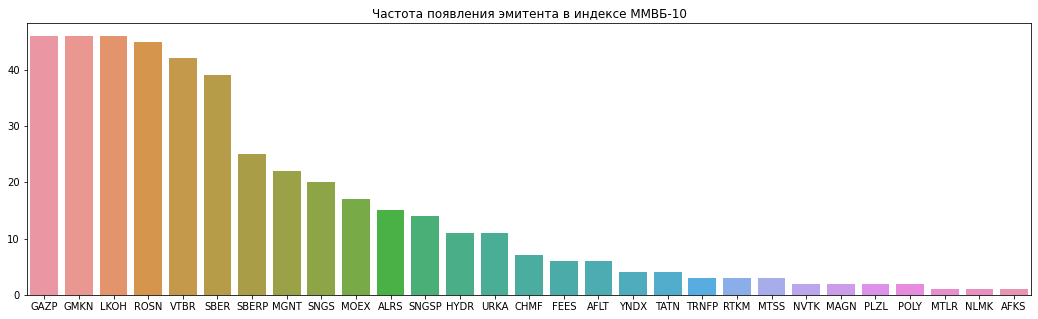

In [8]:
from collections import Counter

countdata = Counter(tickers)
countdata = dict(sorted(countdata.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(18, 5));
sns.barplot(list(countdata.keys()), list(countdata.values()));
plt.title('Частота появления эмитента в индексе ММВБ-10');

plt.savefig(image_dir/'Frequencies of MOEX10 constituents.jpg')

In [9]:
print(f'Всего в нашей выборке оказалось {len(set(tickers))} уникальных эмитентов')

Всего в нашей выборке оказалось 29 уникальных эмитентов


In [10]:
ticker_df = pd.DataFrame({'ticker': list(countdata.keys()),
                          'n_times': list(countdata.values())})
ticker_df.to_csv(data_dir/'imoex10.csv')

При желании, можно выкинуть примерно половину эмитентов - оставить всех, кто не менее 10 раз попадал в индекс, и посчитать портфель для такого "сокращённого состава". Но поскольку задание требует работать не менее чем с 30 эмитентами, придётся оставить всех.

Теперь получим котировки с 2010 по 2021 год с помощью нашего модуля `parser.py`. Он качает данные напрямую по API Мосбиржи - это позволяет надеяться, что цифры, которые мы получим, будут не совсем бессмысленными.

In [11]:
tickers = pd.read_csv(data_dir/'imoex10.csv', usecols=['ticker'])
tickers = tickers.ticker.values.ravel().tolist()

In [12]:
from moexparser import get_historical_data

df = get_historical_data(tickers,
                         start_date = '2010-01-01',
                         end_date = '2021-06-12')
df.head(5)

,GAZP,GMKN,LKOH,ROSN,VTBR,SBER,SBERP,MGNT,SNGS,MOEX,ALRS,SNGSP,HYDR,URKA,CHMF,FEES,AFLT,YNDX,TATN,TRNFP,RTKM,MTSS,NVTK,MAGN,PLZL,POLY,MTLR,NLMK,AFKS
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-06-09,144.40,7029,2025.0,240.36,0.04731,88.89,73.40,8949.0,26.942,65.66,40.800,27.48,0.7299,154.05,296.5,0.05968,58.84,1172.1,207.63,77050,87.69,297.55,405.93,6.835,511.6,314.79,49.7,49.42,44.448
2014-06-10,144.75,6900,2061.4,242.80,0.04700,88.99,73.33,9100.0,27.394,63.88,40.650,27.55,0.7088,157.18,293.4,0.05965,58.85,1170.0,211.00,77055,88.80,296.63,401.37,6.762,507.0,316.49,53.2,48.60,45.499
2014-06-11,146.40,6940,2097.9,249.66,0.04698,89.00,73.69,9070.0,27.559,65.65,40.300,28.15,0.7400,155.28,292.5,0.06015,58.74,1179.9,213.00,76510,88.06,301.20,400.70,6.770,512.8,314.59,51.4,48.33,45.300
2014-06-16,145.20,6649,2149.0,253.30,0.04643,84.85,69.45,8899.0,27.351,65.65,40.038,28.27,0.7320,153.08,285.4,0.05920,56.89,1165.0,219.25,75637,84.30,305.75,407.99,6.848,517.0,324.00,52.0,48.30,45.999
2014-06-17,144.77,6622,2130.0,251.59,0.04680,83.80,67.34,8799.0,27.792,66.30,39.878,28.20,0.7425,152.53,286.5,0.05808,55.06,1185.5,222.77,76065,83.22,301.00,408.34,6.857,513.1,311.50,55.5,48.39,46.100


Необходимо почистить выборку: посмотреть, сколько пропусков для каждого из эмитентов, принять решение, выбрасываем мы его или нет.

<AxesSubplot:title={'center':'Доля пропусков в ценах акций, %'}>

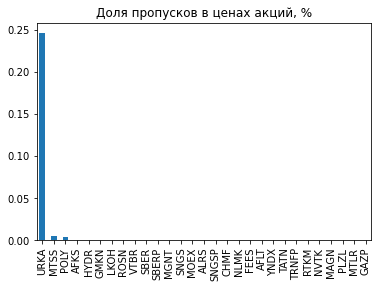

In [14]:
nan_df = {name:round(df[name].isna().sum()/df.shape[0], 3) for name in df.columns}
pd.Series(nan_df).sort_values(ascending=False).plot(kind='bar', title='Доля пропусков в ценах акций, %');

URKA - неликвидный эмитент, его мы можем удалить с чистой совестью. Для оставшихся заполним пропуски предыдущими значениями и проверим, что в выборке не осталось `NaN`.

In [15]:
df = df.drop(columns=['URKA'])
df.fillna(method='ffill', inplace=True)

In [16]:
print(f"В выборке осталось {df.isna().sum().sum()} пропусков.")

В выборке осталось 0 пропусков.


Теперь:
1. Сохраним цены акций в папку data.
2. Сохраним доходности акций в папку data.

In [18]:
df.to_csv(data_dir/'prices.csv')
# рассчитаем лог-доходности, они обладают приятными свойствами
log_rets = np.log(1+df.pct_change().iloc[1:, ])
log_rets.to_csv(data_dir/'log_returns.csv')

### 2. Рассчитать матрицы доходностей и ковариационные матрицы для отобранных акций на различные даты.<a class="anchor" id="covmat"></a>

Для начала неплохо бы посмотреть на данные: какая динамика у цен акций и доходностей, какая у них волатильность, посчитать какие-то выборочные характеристики.

In [22]:
prices = pd.read_csv(data_dir/'prices.csv',
                    header=0,
                    index_col=0,
                    parse_dates=True)

rets = np.log(1+prices.pct_change().iloc[1:, ])

Поскольку цены акций эмитентов совершенно разные, смотреть на них не имеет смысла. Точно так же и график доходностей не несёт много смысла, разве что можно увидеть всплески волатильности:

In [30]:
plt.rcParams.update({'font.size': 18});

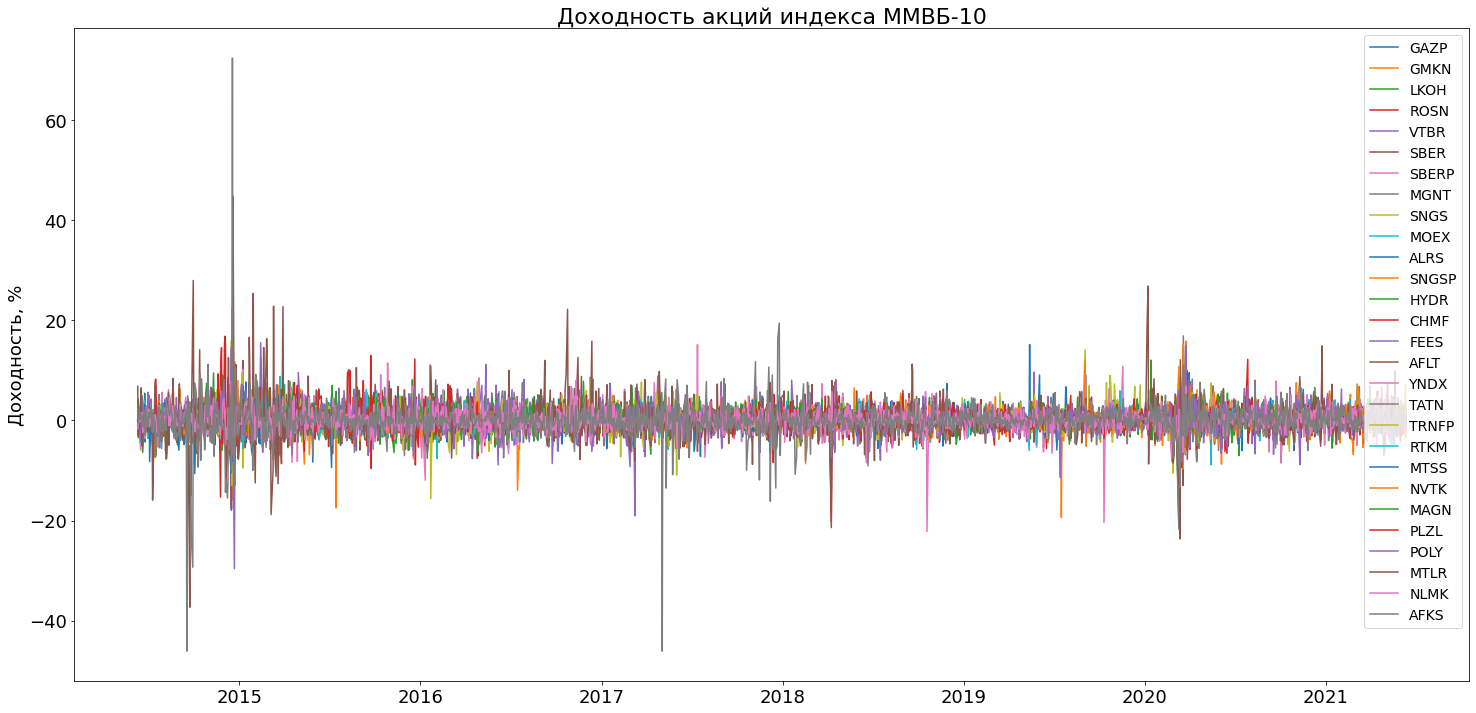

In [58]:
fig, ax = plt.subplots(figsize=(25, 12));

for ticker in rets.columns.tolist():
    ax.plot(rets.index,
             rets[ticker].values*100,
             label=str(ticker));
    
ax.legend(loc='upper right', fontsize=14);
ax.set_title('Доходность акций индекса ММВБ-10', fontsize=22);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Returns of stocks.jpg');

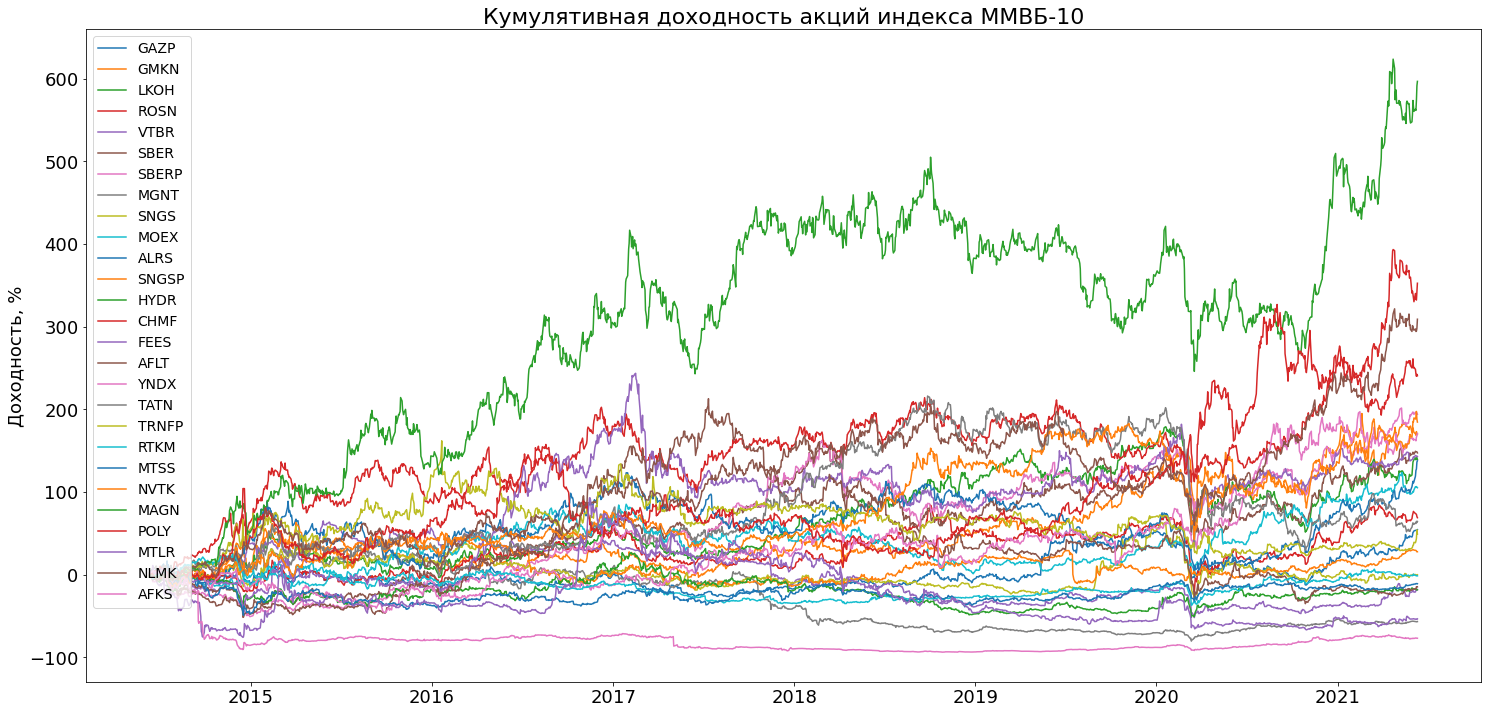

In [63]:
fig, ax = plt.subplots(figsize=(25, 12))

for ticker in rets.drop(columns=['PLZL']).columns.tolist():
    ax.plot(rets.index,
             (np.cumprod(rets[ticker].values+1)-1)*100,
             label=str(ticker));
    
ax.legend(loc='upper left', fontsize=14);
ax.set_title('Кумулятивная доходность акций индекса ММВБ-10', fontsize=22);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Cumulative returns of stocks.jpg');

На прошлом графике мы не нарисовали "Полюс Золото", поскольку его акции выросли гораздо больше всего рынка:

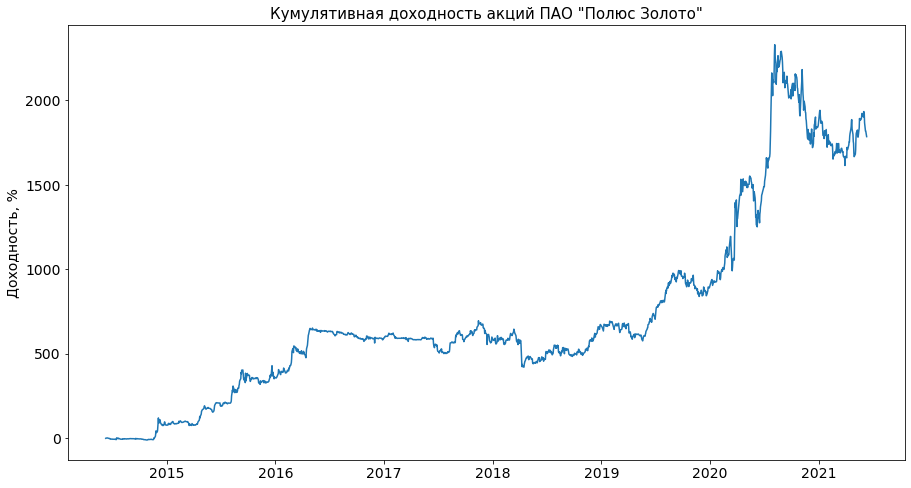

In [74]:
plt.rcParams.update({'font.size': 14});
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(rets.PLZL.index, (np.cumprod(rets.PLZL.values+1)-1)*100);

ax.set_title('Кумулятивная доходность акций ПАО "Полюс Золото"', fontsize=15);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Cumulative returns of PLZL.jpg');

Но график с кумулятивной доходностью, если честно, не очень понятный. Проще посмотреть на таблицу или столбчатый график:

C:\Users\Vladimir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


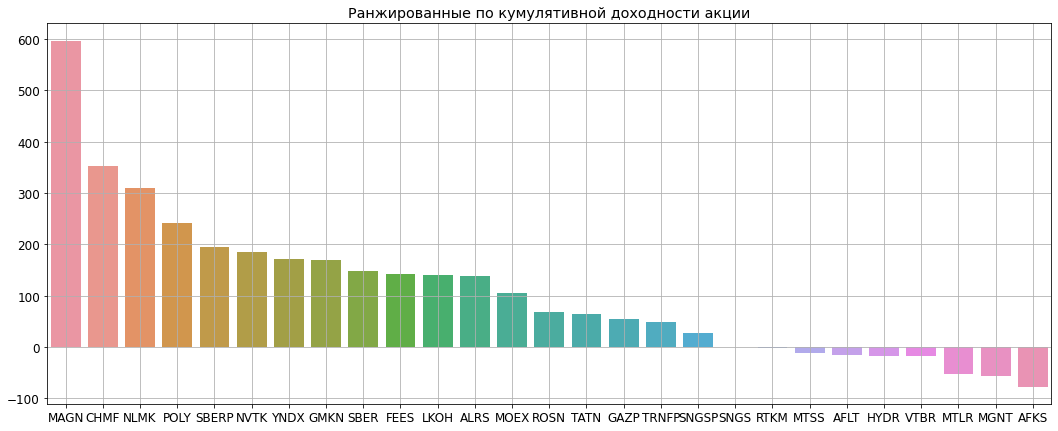

In [100]:
plt.rcParams.update({'font.size': 12});

cumulative_rets = (((rets.drop(columns=['PLZL'])+1).cumprod()-1)*100).iloc[-1, :].sort_values(ascending=False)

plt.figure(figsize=(18, 7));
plt.title('Ранжированные по кумулятивной доходности акции');
sns.barplot(cumulative_rets.index.values.tolist(), cumulative_rets.values.tolist());
plt.grid(True);
plt.savefig(image_dir/'Sorted cumulative returns of stocks.jpg');

Аналогично поступим со стандартными отклонениями акций:

C:\Users\Vladimir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


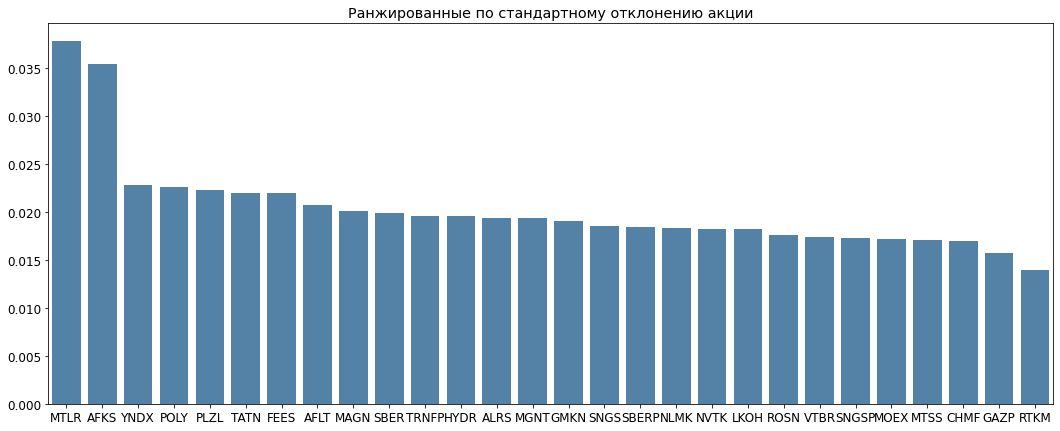

In [99]:
std_data = rets.std().sort_values(ascending=False)

plt.figure(figsize=(18, 7));
plt.title('Ранжированные по стандартному отклонению акции');
sns.barplot(std_data.index.values.tolist(), std_data.values.tolist(), color='steelblue');
plt.savefig(image_dir/'Sorted standard deviations of stocks.jpg');